<a href="https://colab.research.google.com/github/DarcyZeng1/AirlinePassengerReviewsData/blob/main/CSI4106_A4_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ASSIGNMENT 4**

Group Number: 3\
Member Names: Darcy Zeng\
Member Student Numbers: 300238100\
Report Title: Classification Empirical Study on Airline Passenger Reviews\

Goal: The overall goal of this assignment is to perform a classification empirical study and document it. More
specifically, we continue in the same spirit as Assignment 2 and further explore experimental set-up
required for a classification problem, this time looking at deep learning approaches applied on textual
data.

In [ ]:
#let's start by installing spaCy
!pip install spacy

In [ ]:
import spacy
import pandas as pd
import numpy as np

# **1. Choose a Text Classification Dataset**

I choese to use the Airline Passenger Reviews dataset for this assignment.
There is not much much reason why I choese this dataset amont the others, it just looked more interesting.

In [ ]:
#The Airline Passenger Reviews dataset is used. There is not much reason why I decide to use this dataset. I pick random.

url = 'https://raw.githubusercontent.com/DarcyZeng1/AirlinePassengerReviewsData/main/reduced_file_AirPassengerReviews.csv'

Modify the read to only read only 10% of the data because the MLP model will take more than 2 hours to run if I use 100% of the data and there was not much difference in Presicion and recall when using 100% of data and 10% of data.

In [ ]:
#print(url)
# Read only 10% of the data because the MLP model will take more than 2 hours to run if I use 100% of the data.
data = pd.read_csv(url, nrows=int(0.1 * pd.read_csv(url).shape[0]))

In [ ]:
#Example datas
data.head()

,customer_review,NPS Score
0,London to Izmir via Istanbul. First time I'd ...,Passive
1,Istanbul to Bucharest. We make our check in i...,Detractor
2,Rome to Prishtina via Istanbul. I flew with t...,Detractor
3,Flew on Turkish Airlines IAD-IST-KHI and retu...,Promoter
4,Mumbai to Dublin via Istanbul. Never book Tur...,Detractor


Create the NLP pipeline. load() will download the correct model (English).

In [ ]:
nlp = spacy.load("en_core_web_sm")

Applying the pipeline to every sentences creates a Document where every word is a Token object.


In [ ]:
#Apply nlp pipeline to the column that has your sentences.
data['tokenized'] = data['customer_review'].apply(nlp)
#data['tokenized'] = data['NPS Score'].apply(lambda x: nlp(x))

In [ ]:
data.head()

,customer_review,NPS Score,tokenized
0,London to Izmir via Istanbul. First time I'd ...,Passive,"( , London, to, Izmir, via, Istanbul, ., First..."
1,Istanbul to Bucharest. We make our check in i...,Detractor,"( , Istanbul, to, Bucharest, ., We, make, our,..."
2,Rome to Prishtina via Istanbul. I flew with t...,Detractor,"( , Rome, to, Prishtina, via, Istanbul, ., I, ..."
3,Flew on Turkish Airlines IAD-IST-KHI and retu...,Promoter,"( , Flew, on, Turkish, Airlines, IAD, -, IST, ..."
4,Mumbai to Dublin via Istanbul. Never book Tur...,Detractor,"( , Mumbai, to, Dublin, via, Istanbul, ., Neve..."


# **2. Perform some tasks from the NLP pipeline on textual data**

Initialize the derived datasets

In [ ]:
derived_dataset1 = pd.DataFrame(columns = ['Class', 'pos'])
derived_dataset2 = pd.DataFrame(columns = ['Class', 'pos-np'])

Derived-Dataset-1: Lemmatized verbs\
Filtering with verbs as verbs often convey key actions and dynamics in language. By focusing on lemmatized verbs, the classification model can capture essential elements related to sentiment, intention, and behavior, leading to more meaningful insights and accurate results.

In [ ]:
# Function to filter out lemmatized verbs from a spaCy Doc object
def pos_filter_1(doc):
    # Join the lemmatized forms of tokens that have part-of-speech 'VERB'
    return ' '.join([token.lemma_ for token in doc if token.pos_ == 'VERB'])

# Apply the pos_filter_1 function to the 'tokenized' column of the 'data' DataFrame and create a new column 'pos' in the 'derived_dataset1' DataFrame
derived_dataset1['pos'] = data['tokenized'].apply(pos_filter_1)

# Create a new column 'Class' in the 'derived_dataset1' DataFrame and copy values from the 'NPS Score' column of the 'data' DataFrame
derived_dataset1['Class'] = data['NPS Score']


Derived-Dataset-2: Named entities (organizations, money, dates) and lemmatized adjectives

Filtering named entities like organizations, monetary values, and temporal references, along with lemmatized adjectives, in a Classification Empirical Study can impact whether a customer leaves a positive or negative review by capturing key elements such as specific brand experiences, financial considerations, timing-related factors, and the nuanced tone conveyed through descriptive adjectives in their feedback.



In [ ]:
# Function to filter out named entities (ORG, MONEY, DATE) and lemmatized adjectives from a spaCy Doc object
def pos_filter_2(doc):
    # Extract named entities (ORG, MONEY, DATE) from the document
    ents = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'MONEY', 'DATE']]

    # Extract lemmatized adjectives from the document
    adjs = [token.lemma_ for token in doc if token.pos_ == 'ADJ']

    # Join the extracted named entities and adjectives
    return ' '.join(ents + adjs)

# Apply the pos_filter_2 function to the 'tokenized' column of the 'data' DataFrame and create a new column 'pos-np' in the 'derived_dataset2' DataFrame
derived_dataset2['pos-np'] = data['tokenized'].apply(pos_filter_2)

# Create a new column 'Class' in the 'derived_dataset2' DataFrame and copy values from the 'NPS Score' column of the 'data' DataFrame
derived_dataset2['Class'] = data['NPS Score']


In [ ]:
derived_dataset1.head()

,Class,pos
0,Passive,fly find delay miss speak give speak get make ...
1,Detractor,make take go let ™ say overbooke have wait bring
2,Detractor,fly say get fly have try ask connect relax lan...
3,Promoter,return maintain fly leave use seem have show h...
4,Detractor,travel get have ask stay care make keep wait


In [ ]:
derived_dataset2.head()

,Class,pos-np
0,Passive,LHR first good nice great Most contradictory l...
1,Detractor,first last
2,Detractor,the past years Lazy Turkish Airlines several p...
3,Promoter,Turkish Airlines Turkish Airlines 2007 Turkish...
4,Detractor,turkish other more


# **3. Perform a classification empirical study**

In [ ]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import KFold

**3.1 Encode the text as input features woth associated values**

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')

# Original Dataset
X_original_encoded = vectorizer.fit_transform(data['tokenized'].apply(lambda x: ' '.join([token.text for token in x])))
y_original = data['NPS Score']

# Derived-Dataset-1
X_derived1_encoded = vectorizer.transform(derived_dataset1['pos'].apply(lambda x: ' '.join(x.split())))
y_derived1 = derived_dataset1['Class']

# Derived-Dataset-2
X_derived2_encoded = vectorizer.transform(derived_dataset2['pos-np'].apply(lambda x: ' '.join(x.split())))
y_derived2 = derived_dataset2['Class']

**3.2 Define 2 models using some default parameters**

In [ ]:
logistic_regression_model = LogisticRegression(max_iter=1000, random_state=42)
mlp_model = MLPClassifier(max_iter=500, random_state=42)

**3.3 Train/test/evaluate your 2 models (that have default parameters) on your 3 datasets.**

In [ ]:
def train_test_evaluate(model, X, y):
    # a) use 4 fold cross validation
    kf = KFold(n_splits=4, shuffle=True, random_state=42)

    precision_micro = []
    recall_micro = []
    precision_macro = []
    recall_macro = []

    # b) Perform an evaluation with precision/recall measures.
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate precision and recall for micro and macro averages
        precision_micro.append(precision_score(y_test, y_pred, average='micro', zero_division=1))
        recall_micro.append(recall_score(y_test, y_pred, average='micro'))
        precision_macro.append(precision_score(y_test, y_pred, average='macro', zero_division=1))
        recall_macro.append(recall_score(y_test, y_pred, average='macro'))

    # Calculate average precision and recall values over the folds
    avg_precision_micro = np.mean(precision_micro)
    avg_recall_micro = np.mean(recall_micro)
    avg_precision_macro = np.mean(precision_macro)
    avg_recall_macro = np.mean(recall_macro)

    # Return the average precision and recall values
    return avg_precision_micro, avg_recall_micro, avg_precision_macro, avg_recall_macro

**3.3 and 3.4 Train/test/evaluate for originl dataset**

In [ ]:
# Train/test/evaluate Logistic Regression on Original Dataset
print("Logistic Regression Model - Original Dataset:")
log_reg_result_original = train_test_evaluate(logistic_regression_model, X_original_encoded, y_original)
print(f"Precision (Micro): {log_reg_result_original[0]:.3f}")
print(f"Recall (Micro): {log_reg_result_original[1]:.3f}")
print(f"Precision (Macro): {log_reg_result_original[2]:.3f}")
print(f"Recall (Macro): {log_reg_result_original[3]:.3f}")

# Train/test/evaluate MLP on Original Dataset
print("\nMultilayer Perceptron Model - Original Dataset:")
mlp_result_original = train_test_evaluate(mlp_model, X_original_encoded, y_original)
print(f"Precision (Micro): {mlp_result_original[0]:.3f}")
print(f"Recall (Micro): {mlp_result_original[1]:.3f}")
print(f"Precision (Macro): {mlp_result_original[2]:.3f}")
print(f"Recall (Macro): {mlp_result_original[3]:.3f}")

# Experiment 1: Change the hidden layer size
mlp_model_experiment1_original = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
print("\nMultilayer Perceptron Model Experiment 1 - Original Dataset:")
mlp_exp1_result_original = train_test_evaluate(mlp_model_experiment1_original, X_original_encoded, y_original)
print(f"Precision (Micro): {mlp_exp1_result_original[0]:.3f}")
print(f"Recall (Micro): {mlp_exp1_result_original[1]:.3f}")
print(f"Precision (Macro): {mlp_exp1_result_original[2]:.3f}")
print(f"Recall (Macro): {mlp_exp1_result_original[3]:.3f}")

# Experiment 2: Change the activation function
mlp_model_experiment2_sigmoid = MLPClassifier(activation='tanh', max_iter=1000, random_state=42)
print("\nMultilayer Perceptron Model Experiment 2 - Original Dataset:")
mlp_exp2_result_sigmoid = train_test_evaluate(mlp_model_experiment2_sigmoid, X_original_encoded, y_original)
print(f"Precision (Micro): {mlp_exp2_result_sigmoid[0]:.3f}")
print(f"Recall (Micro): {mlp_exp2_result_sigmoid[1]:.3f}")
print(f"Precision (Macro): {mlp_exp2_result_sigmoid[2]:.3f}")
print(f"Recall (Macro): {mlp_exp2_result_sigmoid[3]:.3f}")


Logistic Regression Model - Original Dataset:
Precision (Micro): 0.790
Recall (Micro): 0.790
Precision (Macro): 0.774
Recall (Macro): 0.617

Multilayer Perceptron Model - Original Dataset:
Precision (Micro): 0.784
Recall (Micro): 0.784
Precision (Macro): 0.656
Recall (Macro): 0.640

Multilayer Perceptron Model Experiment 1 - Original Dataset:
Precision (Micro): 0.790
Recall (Micro): 0.790
Precision (Macro): 0.670
Recall (Macro): 0.645

Multilayer Perceptron Model Experiment 2 - Original Dataset:
Precision (Micro): 0.785
Recall (Micro): 0.785
Precision (Macro): 0.656
Recall (Macro): 0.637


**A little experiment for MLP model activation function to find the biggest impact:**\
Since the assignment ask "The parameters should be chosen in a way that they have an impacton the performance of the model.", I decide to compare the impact on each activation function. However, as the bar graph shown in below, there were not much difference on which activation function to use.  

I did this same experiment for the other 2 derived dataset and it also did not have much effect.

Therefore, I just choese the activation function with the highest precision and recall; I will use tanh for each experiment 2.


In [ ]:
#Test each activation model
mlp_model_experiment2_relu = MLPClassifier(activation='relu', max_iter=1000, random_state=42)
print("\nMultilayer Perceptron Model Experiment 2 - ReLU Activation:")
mlp_exp2_result_relu = train_test_evaluate(mlp_model_experiment2_relu, X_original_encoded, y_original)
print(f"Precision (Micro): {mlp_exp2_result_relu[0]:.3f}")
print(f"Recall (Micro): {mlp_exp2_result_relu[1]:.3f}")
print(f"Precision (Macro): {mlp_exp2_result_relu[2]:.3f}")
print(f"Recall (Macro): {mlp_exp2_result_relu[3]:.3f}")

mlp_model_experiment2_linear = MLPClassifier(activation='identity', max_iter=1000, random_state=42)
print("\nMultilayer Perceptron Model Experiment 2 - Linear Activation:")
mlp_exp2_result_linear = train_test_evaluate(mlp_model_experiment2_linear, X_original_encoded, y_original)
print(f"Precision (Micro): {mlp_exp2_result_linear[0]:.3f}")
print(f"Recall (Micro): {mlp_exp2_result_linear[1]:.3f}")
print(f"Precision (Macro): {mlp_exp2_result_linear[2]:.3f}")
print(f"Recall (Macro): {mlp_exp2_result_linear[3]:.3f}")

mlp_model_experiment2_original = MLPClassifier(activation='tanh', max_iter=1000, random_state=42)
print("\nMultilayer Perceptron Model Experiment 2 - Tanh Dataset:")
mlp_exp2_result_original = train_test_evaluate(mlp_model_experiment2_original, X_original_encoded, y_original)
print(f"Precision (Micro): {mlp_exp2_result_original[0]:.3f}")
print(f"Recall (Micro): {mlp_exp2_result_original[1]:.3f}")
print(f"Precision (Macro): {mlp_exp2_result_original[2]:.3f}")
print(f"Recall (Macro): {mlp_exp2_result_original[3]:.3f}")


Multilayer Perceptron Model Experiment 2 - ReLU Activation:
Precision (Micro): 0.784
Recall (Micro): 0.784
Precision (Macro): 0.656
Recall (Macro): 0.640

Multilayer Perceptron Model Experiment 2 - Linear Activation:
Precision (Micro): 0.785
Recall (Micro): 0.785
Precision (Macro): 0.656
Recall (Macro): 0.637

Multilayer Perceptron Model Experiment 2 - Tanh Dataset:
Precision (Micro): 0.785
Recall (Micro): 0.785
Precision (Macro): 0.656
Recall (Macro): 0.637


Plot the outputof each activation function to compare the result

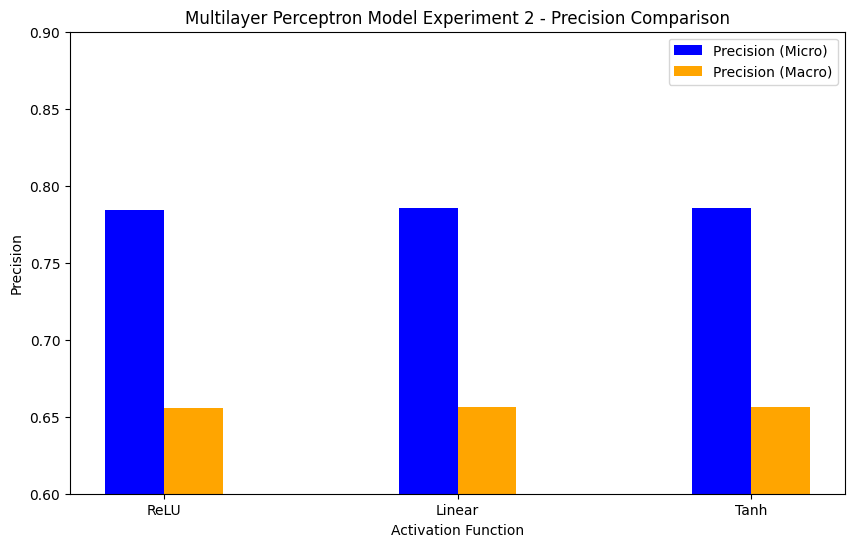

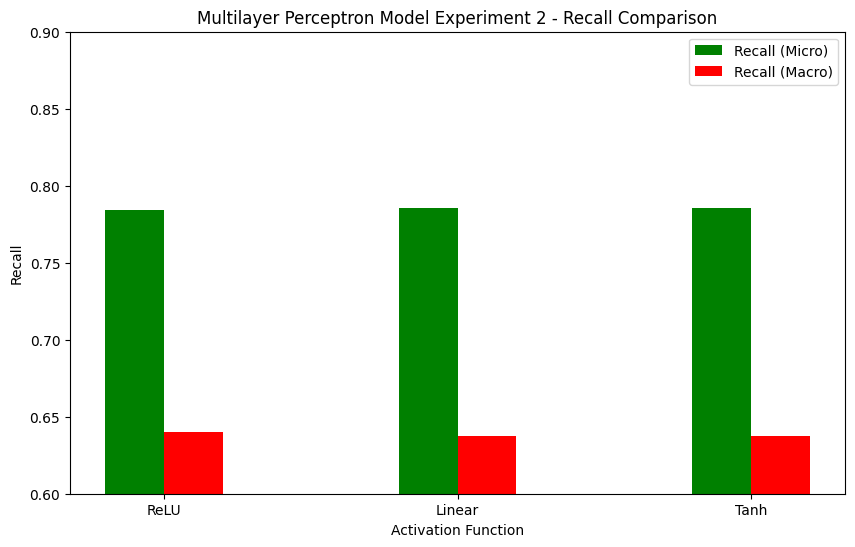

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for ReLU Activation
relu_micro_precision = mlp_exp2_result_relu[0]
relu_micro_recall = mlp_exp2_result_relu[1]
relu_macro_precision = mlp_exp2_result_relu[2]
relu_macro_recall = mlp_exp2_result_relu[3]

# Data for Linear Activation
linear_micro_precision = mlp_exp2_result_linear[0]
linear_micro_recall = mlp_exp2_result_linear[1]
linear_macro_precision = mlp_exp2_result_linear[2]
linear_macro_recall = mlp_exp2_result_linear[3]

# Data for Tanh Activation
original_micro_precision = mlp_exp2_result_original[0]
original_micro_recall = mlp_exp2_result_original[1]
original_macro_precision = mlp_exp2_result_original[2]
original_macro_recall = mlp_exp2_result_original[3]

# Activation labels
activation_labels = ['ReLU', 'Linear', 'Tanh']

# Bar graph for Precision (Micro)
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(activation_labels))

plt.bar(index, [relu_micro_precision, linear_micro_precision, original_micro_precision], color='blue', width=bar_width, label='Precision (Micro)')
plt.bar(index + bar_width, [relu_macro_precision, linear_macro_precision, original_macro_precision], color='orange', width=bar_width, label='Precision (Macro)')

plt.xlabel('Activation Function')
plt.ylabel('Precision')
plt.title('Multilayer Perceptron Model Experiment 2 - Precision Comparison')
plt.xticks(index + bar_width / 2, activation_labels)
plt.legend()
plt.ylim(0.6, 0.9)  # Set y-axis range
plt.show()

# Bar graph for Recall (Micro)
plt.figure(figsize=(10, 6))
plt.bar(index, [relu_micro_recall, linear_micro_recall, original_micro_recall], color='green', width=bar_width, label='Recall (Micro)')
plt.bar(index + bar_width, [relu_macro_recall, linear_macro_recall, original_macro_recall], color='red', width=bar_width, label='Recall (Macro)')

plt.xlabel('Activation Function')
plt.ylabel('Recall')
plt.title('Multilayer Perceptron Model Experiment 2 - Recall Comparison')
plt.xticks(index + bar_width / 2, activation_labels)
plt.legend()
plt.ylim(0.6, 0.9)
plt.show()


**Repeat the above steps for Derived-Dataset-1**

In [ ]:
# Train/test/evaluate Logistic Regression on Derived-Dataset-1
print("\nLogistic Regression Model - Derived-Dataset-1:")
log_reg_result_derived1 = train_test_evaluate(logistic_regression_model, X_derived1_encoded, y_derived1)
print(f"Precision (Micro): {log_reg_result_derived1[0]:.3f}")
print(f"Recall (Micro): {log_reg_result_derived1[1]:.3f}")
print(f"Precision (Macro): {log_reg_result_derived1[2]:.3f}")
print(f"Recall (Macro): {log_reg_result_derived1[3]:.3f}")

# Train/test/evaluate MLP on Derived-Dataset-1
print("\nMultilayer Perceptron Model - Derived-Dataset-1:")
mlp_result_derived1 = train_test_evaluate(mlp_model, X_derived1_encoded, y_derived1)
print(f"Precision (Micro): {mlp_result_derived1[0]:.3f}")
print(f"Recall (Micro): {mlp_result_derived1[1]:.3f}")
print(f"Precision (Macro): {mlp_result_derived1[2]:.3f}")
print(f"Recall (Macro): {mlp_result_derived1[3]:.3f}")

# Experiment 1: Change the hidden layer size
mlp_model_experiment1_derived1 = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
print("\nMultilayer Perceptron Model Experiment 1 - Derived-Dataset-1:")
mlp_exp1_result_derived1 = train_test_evaluate(mlp_model_experiment1_derived1, X_derived1_encoded, y_derived1)
print(f"Precision (Micro): {mlp_exp1_result_derived1[0]:.3f}")
print(f"Recall (Micro): {mlp_exp1_result_derived1[1]:.3f}")
print(f"Precision (Macro): {mlp_exp1_result_derived1[2]:.3f}")
print(f"Recall (Macro): {mlp_exp1_result_derived1[3]:.3f}")

# Experiment 2: Change the activation function
mlp_model_experiment2_derived1 = MLPClassifier(activation='tanh', max_iter=1000, random_state=42)
print("\nMultilayer Perceptron Model Experiment 2 - Derived-Dataset-1:")
mlp_exp2_result_derived1 = train_test_evaluate(mlp_model_experiment2_derived1, X_derived1_encoded, y_derived1)
print(f"Precision (Micro): {mlp_exp2_result_derived1[0]:.3f}")
print(f"Recall (Micro): {mlp_exp2_result_derived1[1]:.3f}")
print(f"Precision (Macro): {mlp_exp2_result_derived1[2]:.3f}")
print(f"Recall (Macro): {mlp_exp2_result_derived1[3]:.3f}")



Logistic Regression Model - Derived-Dataset-1:
Precision (Micro): 0.694
Recall (Micro): 0.694
Precision (Macro): 0.650
Recall (Macro): 0.552

Multilayer Perceptron Model - Derived-Dataset-1:
Precision (Micro): 0.621
Recall (Micro): 0.621
Precision (Macro): 0.529
Recall (Macro): 0.528

Multilayer Perceptron Model Experiment 1 - Derived-Dataset-1:
Precision (Micro): 0.615
Recall (Micro): 0.615
Precision (Macro): 0.529
Recall (Macro): 0.527

Multilayer Perceptron Model Experiment 2 - Derived-Dataset-1:
Precision (Micro): 0.616
Recall (Micro): 0.616
Precision (Macro): 0.531
Recall (Macro): 0.530


**Repeat the above steps for Derived-Dataset-2**


In [ ]:
# Train/test/evaluate Logistic Regression on Derived-Dataset-2
print("\nLogistic Regression Model - Derived-Dataset-2:")
log_reg_result_derived2 = train_test_evaluate(logistic_regression_model, X_derived2_encoded, y_derived2)
print(f"Precision (Micro): {log_reg_result_derived2[0]:.3f}")
print(f"Recall (Micro): {log_reg_result_derived2[1]:.3f}")
print(f"Precision (Macro): {log_reg_result_derived2[2]:.3f}")
print(f"Recall (Macro): {log_reg_result_derived2[3]:.3f}")

# Train/test/evaluate MLP on Derived-Dataset-2
print("\nMultilayer Perceptron Model - Derived-Dataset-2:")
mlp_result_derived2 = train_test_evaluate(mlp_model, X_derived2_encoded, y_derived2)
print(f"Precision (Micro): {mlp_result_derived2[0]:.3f}")
print(f"Recall (Micro): {mlp_result_derived2[1]:.3f}")
print(f"Precision (Macro): {mlp_result_derived2[2]:.3f}")
print(f"Recall (Macro): {mlp_result_derived2[3]:.3f}")

# Experiment 1: Change the hidden layer size
mlp_model_experiment1_derived2 = MLPClassifier(hidden_layer_sizes=(50,),  max_iter=1000, random_state=42)
print("\nMultilayer Perceptron Model Experiment 1 - Derived-Dataset-2:")
mlp_exp1_result_derived2 = train_test_evaluate(mlp_model_experiment1_derived2, X_derived2_encoded, y_derived2)
print(f"Precision (Micro): {mlp_exp1_result_derived2[0]:.3f}")
print(f"Recall (Micro): {mlp_exp1_result_derived2[1]:.3f}")
print(f"Precision (Macro): {mlp_exp1_result_derived2[2]:.3f}")
print(f"Recall (Macro): {mlp_exp1_result_derived2[3]:.3f}")

# Experiment 2: Change the activation function
mlp_model_experiment2_derived2 = MLPClassifier(activation='tanh',  max_iter=1000, random_state=42)
print("\nMultilayer Perceptron Model Experiment 2 - Derived-Dataset-2:")
mlp_exp2_result_derived2 = train_test_evaluate(mlp_model_experiment2_derived2, X_derived2_encoded, y_derived2)
print(f"Precision (Micro): {mlp_exp2_result_derived2[0]:.3f}")
print(f"Recall (Micro): {mlp_exp2_result_derived2[1]:.3f}")
print(f"Precision (Macro): {mlp_exp2_result_derived2[2]:.3f}")
print(f"Recall (Macro): {mlp_exp2_result_derived2[3]:.3f}")


Logistic Regression Model - Derived-Dataset-2:
Precision (Micro): 0.779
Recall (Micro): 0.779
Precision (Macro): 0.645
Recall (Macro): 0.609

Multilayer Perceptron Model - Derived-Dataset-2:
Precision (Micro): 0.734
Recall (Micro): 0.734
Precision (Macro): 0.614
Recall (Macro): 0.614

Multilayer Perceptron Model Experiment 1 - Derived-Dataset-2:
Precision (Micro): 0.733
Recall (Micro): 0.733
Precision (Macro): 0.604
Recall (Macro): 0.608

Multilayer Perceptron Model Experiment 2 - Derived-Dataset-2:
Precision (Micro): 0.732
Recall (Micro): 0.732
Precision (Macro): 0.616
Recall (Macro): 0.615


(0.733271375464684, 0.733271375464684, 0.6039078061022403, 0.6078742838993431)

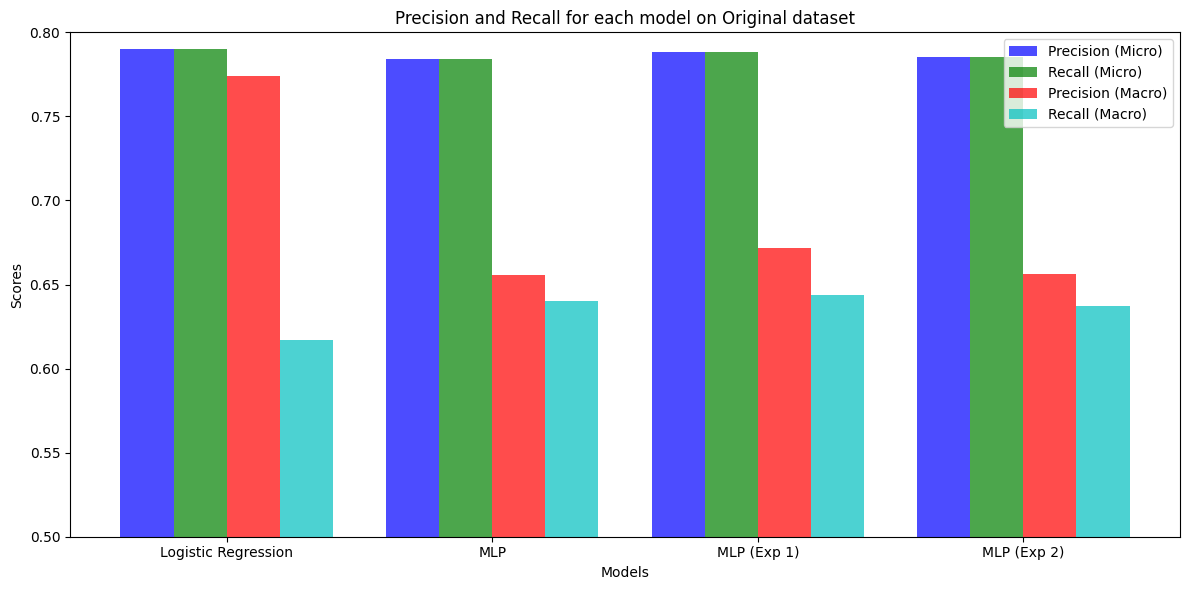

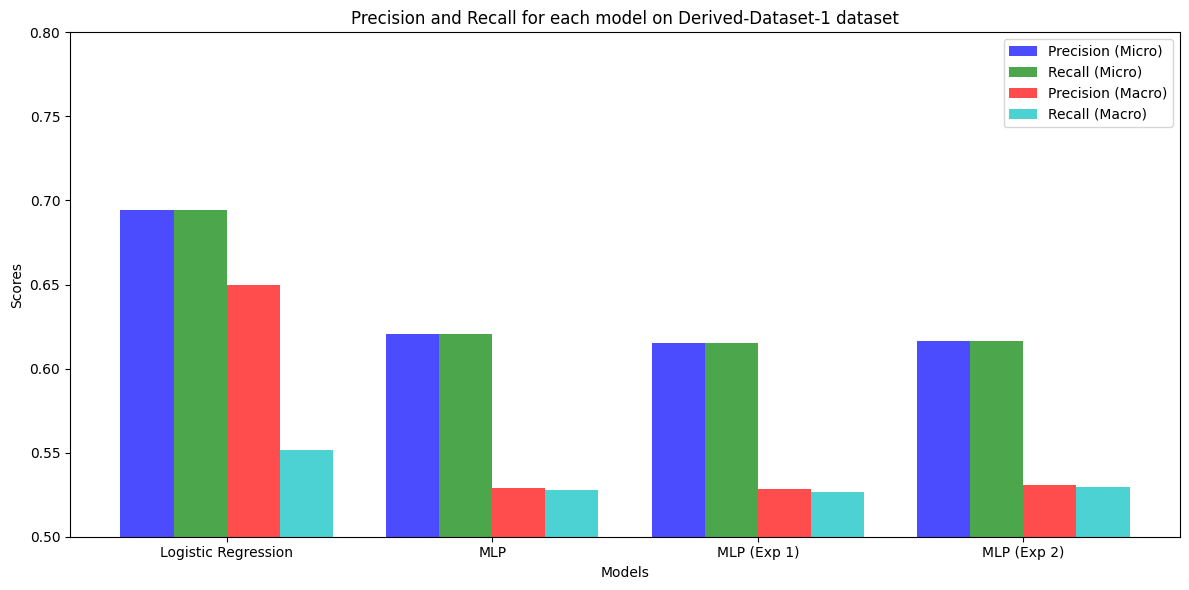

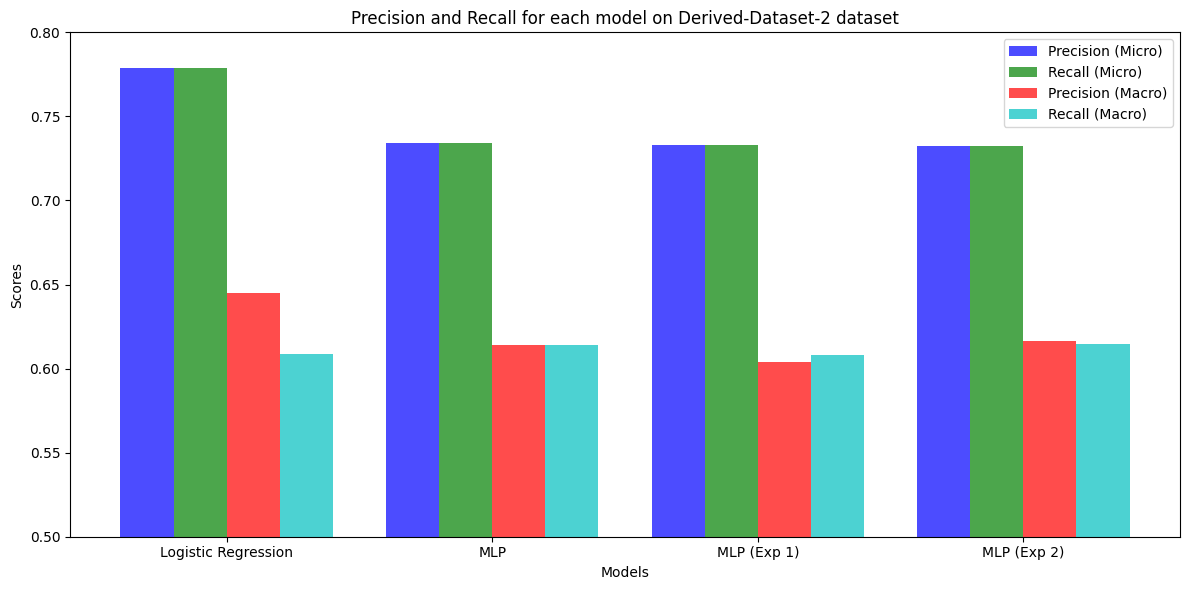

In [ ]:
import matplotlib.pyplot as plt

# Function to plot precision and recall for each model on each dataset
def plot_precision_recall(models, datasets, precision_micro, recall_micro, precision_macro, recall_macro):
    num_models = len(models)
    num_datasets = len(datasets)

    bar_width = 0.2
    index = np.arange(num_models)
    opacity = 0.7

    for i in range(num_datasets):
        # Create a new figure for each dataset
        plt.figure(figsize=(12, 6))

        # Plot bars for precision and recall for each model
        plt.bar(index, precision_micro[i], bar_width, alpha=opacity, color='b', label='Precision (Micro)')
        plt.bar(index + bar_width, recall_micro[i], bar_width, alpha=opacity, color='g', label='Recall (Micro)')
        plt.bar(index + 2 * bar_width, precision_macro[i], bar_width, alpha=opacity, color='r', label='Precision (Macro)')
        plt.bar(index + 3 * bar_width, recall_macro[i], bar_width, alpha=opacity, color='c', label='Recall (Macro)')

        # Set labels, title, and legend
        plt.xlabel('Models')
        plt.ylabel('Scores')
        plt.title(f'Precision and Recall for each model on {datasets[i]} dataset')
        plt.xticks(index + 1.5 * bar_width, models)
        plt.legend()

        # Set the y-axis limits to be between 0.5 and 0.8
        plt.ylim(0.5, 0.8)

        # Adjust layout for better display
        plt.tight_layout()

        # Show the plot for the current dataset
        plt.show()

# Define models, datasets, and corresponding results lists
models = ['Logistic Regression', 'MLP', 'MLP (Exp 1)', 'MLP (Exp 2)']
datasets = ['Original', 'Derived-Dataset-1', 'Derived-Dataset-2']

precision_micro_results = []
recall_micro_results = []
precision_macro_results = []
recall_macro_results = []

# Train/test/evaluate models and collect results
for i, (X, y) in enumerate([(X_original_encoded, y_original), (X_derived1_encoded, y_derived1), (X_derived2_encoded, y_derived2)]):
    precision_micro_row = []
    recall_micro_row = []
    precision_macro_row = []
    recall_macro_row = []

    for j, model in enumerate([logistic_regression_model, mlp_model, mlp_model_experiment1_original, mlp_model_experiment2_original]):
        avg_precision_micro, avg_recall_micro, avg_precision_macro, avg_recall_macro = train_test_evaluate(model, X, y)
        precision_micro_row.append(avg_precision_micro)
        recall_micro_row.append(avg_recall_micro)
        precision_macro_row.append(avg_precision_macro)
        recall_macro_row.append(avg_recall_macro)

    precision_micro_results.append(precision_micro_row)
    recall_micro_results.append(recall_micro_row)
    precision_macro_results.append(precision_macro_row)
    recall_macro_results.append(recall_macro_row)

# Plot the results
plot_precision_recall(models, datasets, precision_micro_results, recall_micro_results, precision_macro_results, recall_macro_results)


# **5. Analyze the obtained results**

In the analysis of the results, it is observed that the logistic regression model consistently outperforms the alternative MLP model in terms of macro precision across the initial dataset. This implies that, on average, the logistic regression model provides more accurate predictions for each class compared to the MLP model

Moving on to the comparison across datasets 1 and 2, the logistic regression model maintains its superiority in terms of both precision and recall, whether considering micro or macro averages. This indicates that the logistic regression model is more robust and effective in handling the specific features extracted from the text data in these datasets. The consistency in performance across different datasets suggests that the logistic regression model might be more resilient to variations in the nature of the textual information.

The modification of the MLP model, as observed in derived dataset 1 (containing only verbs), shows almost no effect. This lack of impact might suggest that the MLP model is not sensitive to changes in the linguistic features represented by verbs alone in this specific dataset. Further investigation into the characteristics of the dataset and the MLP model's architecture could provide insights into why these modifications had minimal impact.

On the other hand, the slight increase in macro precision and recall for the original dataset and derived dataset 2 (containing adjectives and key tokens) after modifying the MLP model is an interesting finding. It indicates that the changes made to the MLP model parameters had a more noticeable effect in the presence of certain linguistic features. Analyzing which specific modifications led to this improvement and understanding the linguistic characteristics that influenced the model's performance can provide valuable insights into optimizing the model for similar types of textual data.

Upon modifying the hidden layer size in the MLP model from the default value of 100 to 50, interesting observations are made. The precision and recall metrics exhibit an increase for the original dataset, suggesting that reducing the complexity of the hidden layer has a positive impact on the model's performance in this specific context. The improvement in precision and recall implies that the model becomes more adept at capturing the underlying patterns in the original dataset with a reduced hidden layer size.

However, the situation is different when considering the derived datasets 1 and 2. In these cases, the precision and recall metrics show a decrease after reducing the hidden layer size. This decline in performance for derived datasets 1 and 2 suggests that the modified architecture with a smaller hidden layer may not be as effective in capturing the relevant features from the linguistic information present in these datasets.

In conclusion, the empirical study highlights the importance of choosing an appropriate model and understanding the impact of linguistic features on classification performance. The consistent superiority of the logistic regression model suggests its robustness in handling diverse textual datasets, while the modifications to the MLP model showcase the potential for fine-tuning to enhance performance, especially in the presence of specific linguistic features.

**Reference**:

SKlearn MLPclissifier: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

Spacy Doc: https://spacy.io/api/doc

SpacyToken: https://spacy.io/api/token

Matlab Bar graph: https://www.mathworks.com/help/matlab/ref/bar.html
